<a href="https://colab.research.google.com/github/JamesPeralta/Gymnos/blob/master/NeuralNetwork/Iteration2/Model_Training_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gymnos Iteration 2
## Gymnos iteration 2 will use a single stream 2D convolutional neural network. For each video we will be passing in only one frame and the AIs prediction will be based on the single frame.



In [0]:
# You can list all of the hardware device running on your instance
from tensorflow.python.client import device_lib

local_devices = device_lib.list_local_devices()

for device in local_devices:
  print("_______________________________________\n" + str(device))

---
## Mount drive and download libraries from Github

In [2]:
from google.colab import drive
import os
import csv
import importlib

# Load the TensorBoard notebook extension
!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip freeze

In [3]:
# Retrieve the Data Generator Library
!curl "https://raw.githubusercontent.com/JamesPeralta/Gymnos/master/NeuralNetwork/Iteration2/GymnosDataGenerator_i2.py?token=AFLRMHIM3FBILWSZXRJKUHC45HRQM" >> GymnosDataGenerator_i2.py
# Retrieve the Helper Functions Library
!curl "https://raw.githubusercontent.com/JamesPeralta/Gymnos/master/NeuralNetwork/Iteration2/HelperFunctions_i2.py?token=AFLRMHMUYT2EXZCEUYWNN4C45GE4W" >> HelperFunctions_i2.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4601  100  4601    0     0  19251      0 --:--:-- --:--:-- --:--:-- 19251
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6054  100  6054    0     0  25330      0 --:--:-- --:--:-- --:--:-- 25436


---
## Imports

In [4]:
import GymnosDataGenerator_i2 as gen
import HelperFunctions_i2 as helper

Using TensorFlow backend.


---
## Create a labels and partitions CSV


In [0]:
csv_location = "/content/drive/My Drive/GYMNOS/Video Dataset/"
labels_location = "/content/drive/My Drive/GYMNOS/Video Dataset/labels.csv"
partitions_location = "/content/drive/My Drive/GYMNOS/Video Dataset/partitions.csv"
squats_location = "/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/"
overhead_location = "/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/"
squats_label = 0
overhead_label = 1

In [0]:
helper.init_labels_csv(labels_location)

In [0]:
# Label the squat dataset
helper.append_to_labels_csv(labels_location, squats_location, squats_label)

# Label the overhead press dataset
helper.append_to_labels_csv(labels_location, overhead_location, overhead_label)

In [0]:
helper.generate_partitions_csv(partitions_location, labels_location)

---
## Read in the labels and partitions CSVs


In [0]:
partition_location = "/content/drive/My Drive/GYMNOS/Video Dataset/partitions.csv"
labels_location = "/content/drive/My Drive/GYMNOS/Video Dataset/labels.csv"

partition = helper.read_partition_csv(partition_location)
labels = helper.read_labels_csv(labels_location)

In [9]:
print(len(partition["train"]))
print(len(partition["validation"]))
print(len(partition["test"]))

1060
15
8


In [7]:
print(partition["train"])

['/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video16.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/IMG_8986.TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/IMG_8689 (1).TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/IMG_8988.TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/video20.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/IMG_8688.TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/video15.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/video21.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video26.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/IMG_8983.TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video4.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video27.MOV', '/cont

In [0]:
# Expand the train partition by 20
new_train = []
for i in range(20):
  for train in partition["train"]:
    new_train.append(train)
    
partition["train"] = new_train

--- 
## Initialize the DataGenerator

In [0]:
import matplotlib.pyplot as plt

In [0]:
train_params = {'frames_per_video': 10,
                'frame_strides': 6,
                'frame_dim': (128, 128),
                'batch_size': 32,
                'n_classes': 2,
                'shuffle': True}

train_generator = gen.DataGenerator(partition["train"], labels, **train_params)

In [0]:
vid_frames, vid_labels = train_generator.__getitem__(3)

In [13]:
print(vid_frames.shape)
print(vid_labels.shape)

(32, 10, 128, 128, 3)
(32, 2)


In [14]:
print(vid_labels[5])

[0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

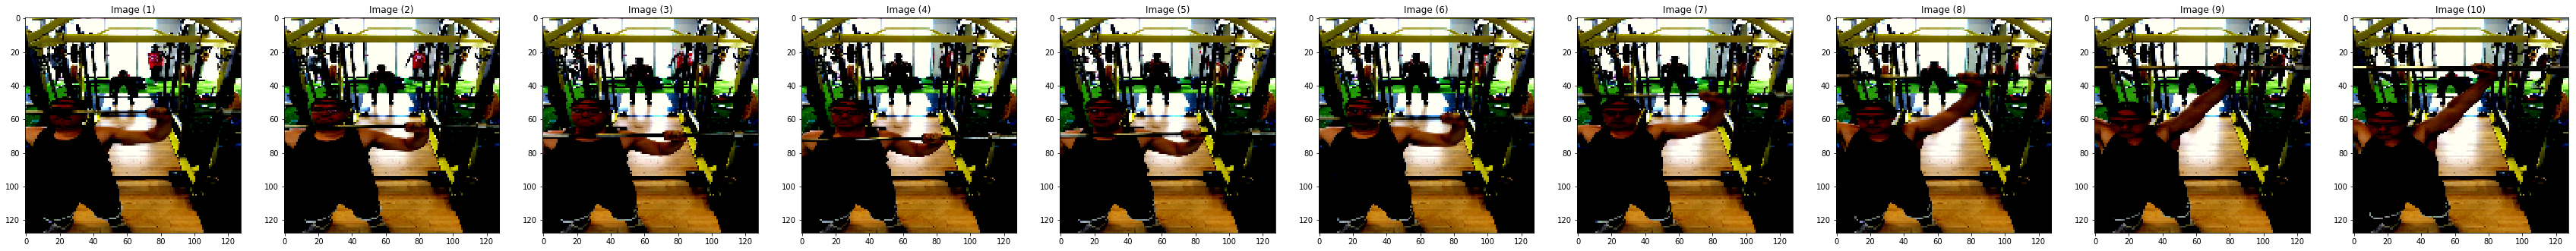

In [15]:
helper.show_images(vid_frames[5])

---
## Model Imports

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

---
## Create the model


In [0]:
def create_model():
  model = Sequential()
  
  model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(10, 128, 128, 3)))
  model.add(MaxPooling3D((2, 2, 2)))
  
  model.add(Conv3D(64, (3, 3, 3), activation='relu', input_shape=(10, 128, 128, 3)))
  model.add(MaxPooling3D((2, 2, 2)))
  
  model.add(Flatten())
  
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  
  model.add(Dense(2, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.01), metrics=['acc'])
  
  return model

In [0]:
model = create_model()

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 8, 126, 126, 32)   2624      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 63, 63, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 61, 61, 64)     55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 30, 30, 64)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.__len__(),
                              epochs=30,
                              verbose=1)

Epoch 1/30
33/33 [==============================] - 1918s 58s/step - loss: 7.3687 - acc: 0.5251
Epoch 2/30
33/33 [==============================] - 1452s 44s/step - loss: 7.5597 - acc: 0.5284
Epoch 3/30
33/33 [==============================] - 1435s 43s/step - loss: 7.5749 - acc: 0.5275
Epoch 4/30
 3/33 [=>............................] - ETA: 22:09 - loss: 8.6830 - acc: 0.4583

In [0]:
iteration_1_location = "/content/drive/My Drive/GYMNOS/Software Development/Implementation Details/Gymnos_i1/gymnos_i1_GPU.h5"

In [0]:
# Save all of your hard work
model.save(iteration_1_location)

---
## TensorBoard Training Visualization

---
## Evaluating the Model
Now that the Model has it's weights initialized, let see how it performs on the test set.

In [0]:
trained_model = load_model(iteration_1_location)

In [0]:
# Parameters
params = {'data_location': "/content/drive/My Drive/GYMNOS/Video Dataset/Frames/",
          'dim': (224, 224, 3),
          'batch_size': 64,
          'n_classes': 2,
          'shuffle': True}

test_generator = gen.DataGenerator(partition["test"], labels, **params)

In [0]:
images, pred_class = test_generator.__getitem__(0)

In [0]:
helper.show_images(images)

In [0]:
model_predictions = trained_model.predict_classes(images)

In [0]:
for index, number in enumerate(model_predictions):
  if number == 0:
    print("Image("+ str(index + 1) + ") is a squat")
  else:
    print("Image("+ str(index + 1) + ") is a overheadpress")